Notebook by: [Juliana Gómez Consuegra](https://www.linkedin.com/in/julianagomezconsuegra/)

In [1]:
!pip install -q datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.9/484.9 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 6.1 MB/s eta 0:00:00


In [2]:
from datasets import load_dataset

#standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Load data

In [3]:
# training set: test is hidden for contest
dataset = load_dataset("quotaclimat/frugalaichallenge-text-train")
print(next(iter(dataset['train'])))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/5.80k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.02M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/248k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1219 [00:00<?, ? examples/s]

{'quote': 'Interesting to note that Oklahoma minimum temperatures in 2011 were in the bottom ten, including the coldest Oklahoma temperature ever recorded, -31F on February 10, 2011.', 'label': '0_not_relevant', 'source': 'FLICC', 'url': 'https://huggingface.co/datasets/fzanartu/FLICCdataset', 'language': 'en', 'subsource': 'CARDS', 'id': None, '__index_level_0__': 1109}


# EDA

In order to not have more than 2x synthetic data, the target number of sentences per category will be 2x the smallest category.

In [4]:
pandas_data = pd.DataFrame(dataset['train'])
pandas_data.head()

,quote,label,source,url,language,subsource,id,__index_level_0__
0,Interesting to note that Oklahoma minimum temp...,0_not_relevant,FLICC,https://huggingface.co/datasets/fzanartu/FLICC...,en,CARDS,None,1109
1,REPORT ON GEO ENGINEERING A.k.a. man-made FAKE...,6_proponents_biased,FLICC,https://huggingface.co/datasets/fzanartu/FLICC...,en,hamburg_test3,None,100
2,"To realize, yes, climate change is a real prob...",3_not_bad,Desmog,https://www.desmog.com/jordan-peterson/,en,None,None,4086
3,The fluctuations in the carbon dioxide concent...,2_not_human,Desmog,https://www.desmog.com/harry-n-a-priem/,en,None,None,3639
4,I know the comments that were made after that ...,0_not_relevant,Desmog,https://www.desmog.com/james-inhofe/,en,None,None,3256


<Axes: >

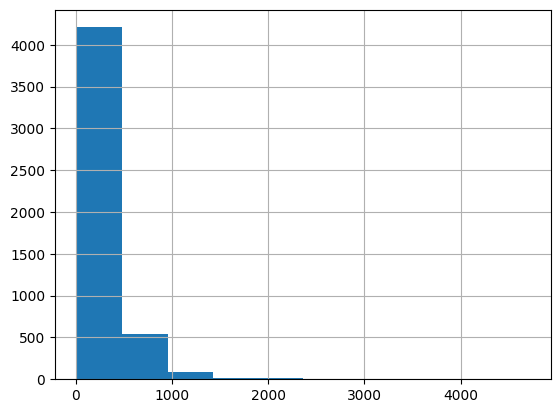

In [5]:
#num char
pandas_data['quote'].str.len().hist()

In [6]:
pandas_data['label'].value_counts()

,count
label,
0_not_relevant,1311
6_proponents_biased,643
5_science_unreliable,641
4_solutions_harmful_unnecessary,614
1_not_happening,587
2_not_human,565
3_not_bad,289
7_fossil_fuels_needed,222


In [9]:
sum(pandas_data['label'].value_counts())
(222/4872)*100

4.556650246305419

<Axes: xlabel='label'>

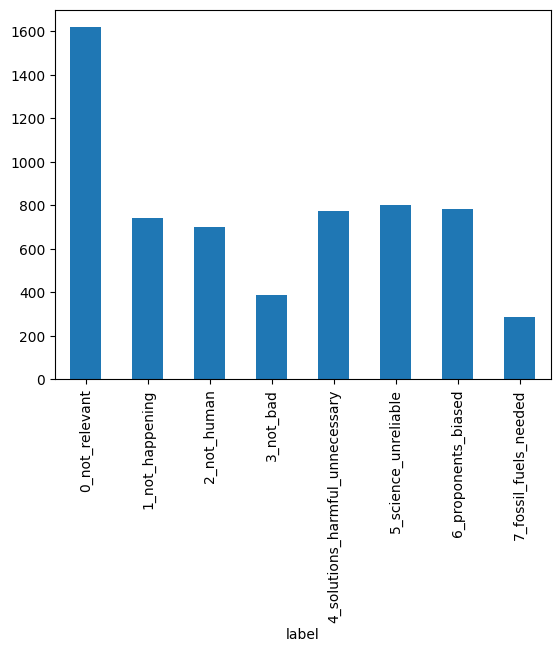

In [ ]:
pandas_data['label'].value_counts().sort_index().plot(kind='bar', rot=90)

In [ ]:
pandas_data[pandas_data['label']== '3_not_bad'].quote.iloc[0]

'Fun fact: 0 people have ever died from climate change. That number is expected to remain constant'

In [ ]:
# find out how many sentences need to be translated and back-translated to reach  800, per category label
target_num = 800

for category in pandas_data['label'].unique():
  if pandas_data['label'].value_counts()[category] < target_num:
    missing = target_num - pandas_data['label'].value_counts()[category]
    print(category,missing)


1_not_happening 59
4_solutions_harmful_unnecessary 26
6_proponents_biased 18
7_fossil_fuels_needed 513
2_not_human 98
3_not_bad 414


In [ ]:
# Target number of sentences per class
target_count= 800
# target_count = pandas_data[pandas_data['label']=='7_fossil_fuels_needed'].shape[0]*2
label_counts = pandas_data['label'].value_counts()
missing_counts = {label: max(0, target_count - count) for label, count in label_counts.items()}

print(missing_counts)

missing_sentences = pd.DataFrame(columns=['sample_quote', 'label'])

for label, missing_count in missing_counts.items():
    label_df = pandas_data[pandas_data['label'] == label]
    sampled_df = label_df.sample(n=min(missing_count, len(label_df)), replace=False)
    missing_sentences = pd.concat([missing_sentences, sampled_df.rename(columns={'quote': 'sample_quote'})], ignore_index=True)


print(len(missing_sentences))

{'0_not_relevant': 0, '5_science_unreliable': 0, '6_proponents_biased': 18, '4_solutions_harmful_unnecessary': 26, '1_not_happening': 59, '2_not_human': 98, '3_not_bad': 414, '7_fossil_fuels_needed': 513}
874


In [ ]:
label_counts = missing_sentences['label'].value_counts()
label_counts

,count
label,
3_not_bad,386
7_fossil_fuels_needed,287
2_not_human,98
1_not_happening,59
4_solutions_harmful_unnecessary,26
6_proponents_biased,18


In [ ]:
missing_sentences.head()

,sample_quote,label,source,url,language,subsource,id,__index_level_0__
0,The Pope is perfectly entitled to have his opi...,6_proponents_biased,Desmog,https://www.desmog.com/george-will/,en,None,None,2775.0
1,I think it’s important to see the problem with...,6_proponents_biased,Desmog,https://www.desmog.com/vivek-ramaswamy/,en,None,None,4530.0
2,"This is doomsday-cult scenario stuff, we shoul...",6_proponents_biased,Desmog,https://www.desmog.com/julia-hartley-brewer/,en,None,None,5779.0
3,"The alarmists screech and holler, but when the...",6_proponents_biased,Desmog,https://www.desmog.com/mackinac-center-public-...,en,None,None,4105.0
4,What is lost in the climate change hyperbole f...,6_proponents_biased,Desmog,https://www.desmog.com/mandy-gunasekara/,en,None,None,2484.0


In [ ]:
missing_sentences.iloc[0]['sample_quote']

'The Pope is perfectly entitled to have his opinions about scientific problems such as this, but entitled to no particular deference. He turns this into a moral problem. He comes out of a Latin American strand of Catholicism that is frankly, sort of anti-capitalist and anti-bourgeois, and confused about how to help the poor,” Will says He says we have to burn less coal. You’re going to raise the price of electricity. It doesn’t mean a thing to the four of us, but it means a lot to poor people if the price of electricity goes up. And then he says the planet is in the grip of consumerism. There are about 2 billion people on this planet who wish to be in the grip of consumerism, but they’re too poor.'

# Use LLM to translate and backtranslate some sentences

- T5 only translates from English into another language, not back.
- M2M: https://github.com/datasci-w266/2023-fall-main/blob/master/materials/lesson_notebooks/lesson_6_Machine_Translation.ipynb
- Backtranslation leaves some things in Spanish!

In [ ]:
from transformers import M2M100Config, M2M100Tokenizer,M2M100ForConditionalGeneration

In [ ]:
#from english to spanish

en_text = "Fun fact: 0 people have ever died from climate change. That number is expected to remain constant"

tokenizer = M2M100Tokenizer.from_pretrained("facebook/m2m100_418M", src_lang="en")
model = M2M100ForConditionalGeneration.from_pretrained("facebook/m2m100_418M")

encoded_en = tokenizer(en_text, return_tensors="pt")

generated_tokens = model.generate(**encoded_en, forced_bos_token_id=tokenizer.get_lang_id("es"))
translated_es = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)

tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/298 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/3.71M [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.14k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/908 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.94G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/233 [00:00<?, ?B/s]

['Funny fact: 0 personas han muerto alguna vez por el cambio climático. ese número se espera permanecer constante']

In [ ]:
# back translate into english
es_text = translated_es[0]

tokenizer = M2M100Tokenizer.from_pretrained("facebook/m2m100_418M", src_lang="en")
model = M2M100ForConditionalGeneration.from_pretrained("facebook/m2m100_418M")

encoded_es = tokenizer(es_text, return_tensors="pt")

generated_tokens = model.generate(**encoded_es, forced_bos_token_id=tokenizer.get_lang_id("en"))
tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)

['Funny fact: 0 people have died some time for climate change. that number se espera permanecer constante']

## Marian MT model

https://huggingface.co/docs/transformers/main/en/model_doc/marian#transformers.MarianMTModel

Works pretty well with sample sentence.

In [ ]:
from transformers import AutoTokenizer, MarianMTModel

src = "en"  # source language
trg = "es"  # target language

model_name = f"Helsinki-NLP/opus-mt-{src}-{trg}"
model = MarianMTModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

sample_text = "Fun fact: 0 people have ever died from climate change. That number is expected to remain constant"
batch = tokenizer([sample_text], return_tensors="pt")

generated_ids = model.generate(**batch)
tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

config.json:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/312M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/802k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/826k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.59M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


'Dato curioso: 0 personas han muerto alguna vez a causa del cambio climático. Se espera que ese número permanezca constante'

In [ ]:
#back translate

src = "es"  # source language
trg = "en"  # target language

model_name = f"Helsinki-NLP/opus-mt-{src}-{trg}"
model = MarianMTModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

sample_text = "Dato curioso: 0 personas han muerto alguna vez a causa del cambio climático. Se espera que ese número permanezca constante"
batch = tokenizer([sample_text], return_tensors="pt")

generated_ids = model.generate(**batch)
tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

config.json:   0%|          | 0.00/1.44k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/312M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/826k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/802k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.59M [00:00<?, ?B/s]

'Curious fact: 0 people have ever died from climate change. It is expected that this number will remain constant'

# Generate backtranslations

In [ ]:
from transformers import AutoTokenizer, MarianMTModel


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

## for one sentence from dataset

In [ ]:
# from en-es-en. Reference sentence: "To those of us who have been studying the global warming scare in some detail, the answer is depressingly obvious. It's because in the last decade or so, the climate change industry has become so vast and all encompassing, employing so many people, it simply can not be allowed to fail ."
src = "en"  # source language
trg = "es"  # target language

model_name = f"Helsinki-NLP/opus-mt-{src}-{trg}"
model = MarianMTModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

sample_text = missing_sentences.iloc[0]['sample_quote']
batch = tokenizer([sample_text], return_tensors="pt")

generated_ids = model.generate(**batch)
spanish_sentence = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

#####
src = "es"  # source language
trg = "en"  # target language

model_name = f"Helsinki-NLP/opus-mt-{src}-{trg}"
model = MarianMTModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

sample_text = spanish_sentenceo
batch = tokenizer([sample_text], return_tensors="pt")

generated_ids = model.generate(**batch)
tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]


/usr/local/lib/python3.11/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


'For those of us who have been studying the fear of global warming in some detail, the answer is depressingly obvious. It’s because in the last decade or so, the climate change industry has become so vast and comprehensive, employing so many people, you just can’t let it fail.'

## Generate backtranslations for a sentence and save as pandas df

In [ ]:
# from en-es-en. Reference sentence: "To those of us who have been studying the global warming scare in some detail, the answer is depressingly obvious. It's because in the last decade or so, the climate change industry has become so vast and all encompassing, employing so many people, it simply can not be allowed to fail ."
src = "en"  # source language
trg = "es"  # target language

model_name = f"Helsinki-NLP/opus-mt-{src}-{trg}"
model = MarianMTModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

sample_text = missing_sentences.iloc[0]['sample_quote']
sample_label = missing_sentences.iloc[0]['label']
batch = tokenizer([sample_text], return_tensors="pt")

generated_ids = model.generate(**batch)
spanish_sentence = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

#####
src = "es"  # source language
trg = "en"  # target language

model_name = f"Helsinki-NLP/opus-mt-{src}-{trg}"
model = MarianMTModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

sample_text = spanish_sentence
batch = tokenizer([sample_text], return_tensors="pt")

generated_ids = model.generate(**batch)
bt_text = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

#create a new pandas dataframe with bt and label, and the remaining columns from missing sentences with empty values
new_row = pd.DataFrame({'quote': [bt_text], 'label': [sample_label], 'source': '', 'url': '', 'language': '', 'subsource': '', 'id': '', '__index_level_0__': ''})
new_row

/usr/local/lib/python3.11/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


,quote,label,source,url,language,subsource,id,__index_level_0__
0,For those of us who have been studying the fea...,6_proponents_biased,,,,,,


## Generate backtranslations for 10 sentences

In [ ]:
# Create a new dataframe to store results
results = pd.DataFrame(columns=['sample_quote', 'label', 'source', 'url', 'language', 'subsource', 'id', '__index_level_0__'])

# Process the first 10 rows
for i in range(10):
    src = "en"  # source language
    trg = "es"  # target language

    model_name = f"Helsinki-NLP/opus-mt-{src}-{trg}"
    model = MarianMTModel.from_pretrained(model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    sample_text = missing_sentences.iloc[i]['sample_quote']
    sample_label = missing_sentences.iloc[i]['label']
    batch = tokenizer([sample_text], return_tensors="pt")

    generated_ids = model.generate(**batch)
    spanish_sentence = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

    #####
    src = "es"  # source language
    trg = "en"  # target language

    model_name = f"Helsinki-NLP/opus-mt-{src}-{trg}"
    model = MarianMTModel.from_pretrained(model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    sample_text = spanish_sentence
    batch = tokenizer([sample_text], return_tensors="pt")

    generated_ids = model.generate(**batch)
    bt_text = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

    # Append the new row to the results dataframe
    new_row = pd.DataFrame({'sample_quote': [bt_text], 'label': [sample_label], 'source': '', 'url': '', 'language': '', 'subsource': '', 'id': '', '__index_level_0__': ''})
    results = pd.concat([results, new_row], ignore_index=True)

# Display the first few rows of the results
results.head()


/usr/local/lib/python3.11/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


,sample_quote,label,source,url,language,subsource,id,__index_level_0__
0,The Pope has the perfect right to have his opi...,6_proponents_biased,,,,,,
1,I think it’s important to see the problem with...,6_proponents_biased,,,,,,
2,This is a thing from the final judgment day sc...,6_proponents_biased,,,,,,
3,"Alarmists scream and shout, but when their cla...",6_proponents_biased,,,,,,
4,What is lost in the hyperbole of climate chang...,6_proponents_biased,,,,,,


In [ ]:
missing_sentences.head()

,original_index,sample_quote,label,source,url,language,subsource,id,__index_level_0__,connection_id,type
0,0,The Pope is perfectly entitled to have his opi...,6_proponents_biased,Desmog,https://www.desmog.com/george-will/,en,None,None,2775.0,1,og
1,1,I think it’s important to see the problem with...,6_proponents_biased,Desmog,https://www.desmog.com/vivek-ramaswamy/,en,None,None,4530.0,2,og
2,2,"This is doomsday-cult scenario stuff, we shoul...",6_proponents_biased,Desmog,https://www.desmog.com/julia-hartley-brewer/,en,None,None,5779.0,3,og
3,3,"The alarmists screech and holler, but when the...",6_proponents_biased,Desmog,https://www.desmog.com/mackinac-center-public-...,en,None,None,4105.0,4,og
4,4,What is lost in the climate change hyperbole f...,6_proponents_biased,Desmog,https://www.desmog.com/mandy-gunasekara/,en,None,None,2484.0,5,og


### Join og and bt

In [ ]:
# Add a connection_id and type column to both dataframes
missing_sentences['connection_id'] = range(1, len(missing_sentences) + 1)
missing_sentences['type'] = 'og'

results['connection_id'] = range(1, len(results) + 1)
results['type'] = 'bt'

# Combine the two dataframes
joined_dataframe = pd.concat([missing_sentences, results], ignore_index=True)

# Create a new column that combines the type and connection_id
joined_dataframe['connection'] = joined_dataframe['type'] + '_' + joined_dataframe['connection_id'].astype(str)

# Sort the dataframe by connection_id to keep original and backtranslated pairs together
joined_dataframe = joined_dataframe.sort_values('connection_id')

# Display the first few rows of the joined dataframe
joined_dataframe[['sample_quote', 'label', 'connection']].head(4)

,sample_quote,label,connection
0,The Pope is perfectly entitled to have his opi...,6_proponents_biased,og_1
874,The Pope has the perfect right to have his opi...,6_proponents_biased,bt_1
1,I think it’s important to see the problem with...,6_proponents_biased,og_2
875,I think it’s important to see the problem with...,6_proponents_biased,bt_2


## Generate backtranslations for all sentences

In [ ]:
len(missing_sentences)

874

In [ ]:
# Create a new dataframe to store results
results = pd.DataFrame(columns=['sample_quote', 'label', 'source', 'url', 'language', 'subsource', 'id', '__index_level_0__'])

for i in range(len(missing_sentences)):
    src = "en"  # source language
    trg = "es"  # target language

    model_name = f"Helsinki-NLP/opus-mt-{src}-{trg}"
    model = MarianMTModel.from_pretrained(model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    sample_text = missing_sentences.iloc[i]['sample_quote']
    sample_label = missing_sentences.iloc[i]['label']
    batch = tokenizer([sample_text], return_tensors="pt")

    generated_ids = model.generate(**batch)
    spanish_sentence = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

    #####
    src = "es"  # source language
    trg = "en"  # target language

    model_name = f"Helsinki-NLP/opus-mt-{src}-{trg}"
    model = MarianMTModel.from_pretrained(model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    sample_text = spanish_sentence
    batch = tokenizer([sample_text], return_tensors="pt")

    generated_ids = model.generate(**batch)
    bt_text = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

    # Append the new row to the results dataframe
    new_row = pd.DataFrame({'sample_quote': [bt_text], 'label': [sample_label], 'source': '', 'url': '', 'language': '', 'subsource': '', 'id': '', '__index_level_0__': ''})
    results = pd.concat([results, new_row], ignore_index=True)
    print(len(results))

# Display the first few rows of the results
results.head()

/usr/local/lib/python3.11/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


,sample_quote,label,source,url,language,subsource,id,__index_level_0__
0,The Pope has the perfect right to have his opi...,6_proponents_biased,,,,,,
1,I think it’s important to see the problem with...,6_proponents_biased,,,,,,
2,This is a thing from the final judgment day sc...,6_proponents_biased,,,,,,
3,"Alarmists scream and shout, but when their cla...",6_proponents_biased,,,,,,
4,What is lost in the hyperbole of climate chang...,6_proponents_biased,,,,,,


In [ ]:
# Add a connection_id and type column to both dataframes
missing_sentences['connection_id'] = range(1, len(missing_sentences) + 1)
missing_sentences['type'] = 'og'

results['connection_id'] = range(1, len(results) + 1)
results['type'] = 'bt'

# Combine the two dataframes
joined_dataframe = pd.concat([missing_sentences, results], ignore_index=True)

# Create a new column that combines the type and connection_id
joined_dataframe['connection'] = joined_dataframe['type'] + '_' + joined_dataframe['connection_id'].astype(str)

# Sort the dataframe by connection_id to keep original and backtranslated pairs together
joined_dataframe = joined_dataframe.sort_values('connection_id')

# Display the first few rows of the joined dataframe
joined_dataframe[['sample_quote', 'label', 'connection']].head(4)

,sample_quote,label,connection
0,The Pope is perfectly entitled to have his opi...,6_proponents_biased,og_1
874,The Pope has the perfect right to have his opi...,6_proponents_biased,bt_1
1,I think it’s important to see the problem with...,6_proponents_biased,og_2
875,I think it’s important to see the problem with...,6_proponents_biased,bt_2


In [ ]:
#export joined_dataframe as csv
joined_dataframe.to_csv('joined_dataframe.csv', index=False)

# Join to original dataframe and remove duplicates in og sentences

In [ ]:
joined_dataframe = pd.read_csv('joined_dataframe.csv')

#rename sample_quote to quote
joined_dataframe = joined_dataframe.rename(columns={'sample_quote': 'quote'})

#remove original_index
joined_dataframe = joined_dataframe.drop(columns=['original_index'])

joined_dataframe.head()

,quote,label,source,url,language,subsource,id,__index_level_0__,connection_id,type,connection
0,The Pope is perfectly entitled to have his opi...,6_proponents_biased,Desmog,https://www.desmog.com/george-will/,en,NaN,NaN,2775.0,1,og,og_1
1,The Pope has the perfect right to have his opi...,6_proponents_biased,NaN,NaN,NaN,NaN,NaN,NaN,1,bt,bt_1
2,I think it’s important to see the problem with...,6_proponents_biased,Desmog,https://www.desmog.com/vivek-ramaswamy/,en,NaN,NaN,4530.0,2,og,og_2
3,I think it’s important to see the problem with...,6_proponents_biased,NaN,NaN,NaN,NaN,NaN,NaN,2,bt,bt_2
4,"This is doomsday-cult scenario stuff, we shoul...",6_proponents_biased,Desmog,https://www.desmog.com/julia-hartley-brewer/,en,NaN,NaN,5779.0,3,og,og_3


In [ ]:
pandas_data['connection_id'] = range(1, len(pandas_data) + 1)
pandas_data['type'] = 'oga'
pandas_data['connection'] = pandas_data['type'] + '_' + pandas_data['connection_id'].astype(str)
pandas_data.head()

,quote,label,source,url,language,subsource,id,__index_level_0__,connection_id,type,connection
0,"There is clear, compelling evidence that many ...",5_science_unreliable,FLICC,https://huggingface.co/datasets/fzanartu/FLICC...,en,CARDS,None,0,1,oga,oga_1
1,"For most of the Holocene (last 10k years), sea...",1_not_happening,FLICC,https://huggingface.co/datasets/fzanartu/FLICC...,en,hamburg_test1,None,1,2,oga,oga_2
2,"China, which hosts U.N. climate talks next wee...",4_solutions_harmful_unnecessary,FLICC,https://huggingface.co/datasets/fzanartu/FLICC...,en,CARDS,None,2,3,oga,oga_3
3,And the fabricated documents (which Dr. Mann a...,0_not_relevant,FLICC,https://huggingface.co/datasets/fzanartu/FLICC...,en,CARDS,None,3,4,oga,oga_4
4,It's going to be 42 here today and the hottest...,1_not_happening,FLICC,https://huggingface.co/datasets/fzanartu/FLICC...,en,hamburg_test3,None,4,5,oga,oga_5


In [ ]:
all_sentences = pd.concat([joined_dataframe, pandas_data], ignore_index=True)

#sort by type and connection
all_sentences = all_sentences.sort_values(by=['type', 'connection'])


#remove duplicates in quote
all_sentences = all_sentences.drop_duplicates(subset='quote', keep='first')

all_sentences.head()

,quote,label,source,url,language,subsource,id,__index_level_0__,connection_id,type,connection
1,The Pope has the perfect right to have his opi...,6_proponents_biased,NaN,NaN,NaN,NaN,NaN,NaN,1,bt,bt_1
18,If you go far enough a university student wrot...,6_proponents_biased,NaN,NaN,NaN,NaN,NaN,NaN,10,bt,bt_10
199,Concern is focused on the apparent weakening o...,1_not_happening,NaN,NaN,NaN,NaN,NaN,NaN,100,bt,bt_100
201,Green phenomena and climate change nuts hate t...,1_not_happening,NaN,NaN,NaN,NaN,NaN,NaN,101,bt,bt_101
203,The report falsely states that global warming ...,1_not_happening,NaN,NaN,NaN,NaN,NaN,NaN,102,bt,bt_102


In [ ]:
# check the pope example
all_sentences[all_sentences['quote'].str.contains('Pope')]

,quote,label,source,url,language,subsource,id,__index_level_0__,connection_id,type,connection
1,The Pope has the perfect right to have his opi...,6_proponents_biased,NaN,NaN,NaN,NaN,NaN,NaN,1,bt,bt_1
1333,Everything the Pope is saying on the subject o...,7_fossil_fuels_needed,NaN,NaN,NaN,NaN,NaN,NaN,667,bt,bt_667
0,The Pope is perfectly entitled to have his opi...,6_proponents_biased,Desmog,https://www.desmog.com/george-will/,en,NaN,NaN,2775.0,1,og,og_1
3555,Although the authors of the pollution report h...,0_not_relevant,Desmog,https://www.desmog.com/mikko-paunio/,en,None,None,1807.0,1808,oga,oga_1808
3833,Everyone is going to ride the Pope now. Isn’t ...,0_not_relevant,Desmog,https://www.desmog.com/james-inhofe/,en,None,None,2097.0,2086,oga,oga_2086
4052,The Pope is right. It is a good idea to ask ac...,0_not_relevant,Desmog,https://www.desmog.com/william-briggs/,en,None,None,2331.0,2305,oga,oga_2305
4204,Pope Francis advocates the global warming agen...,6_proponents_biased,Desmog,https://www.desmog.com/tim-ball/,en,None,None,2493.0,2457,oga,oga_2457
4846,"Pope Francis’s heart is in the right place, bu...",6_proponents_biased,Desmog,https://www.desmog.com/jim-lakely/,en,None,None,3182.0,3099,oga,oga_3099
5277,The Pope is right. It is a good idea to ask ac...,4_solutions_harmful_unnecessary,Desmog,https://www.desmog.com/william-briggs/,en,None,None,3647.0,3530,oga,oga_3530
5642,The United Nations is not telling the entire t...,6_proponents_biased,Desmog,https://www.desmog.com/jim-lakely/,en,None,None,4042.0,3895,oga,oga_3895


In [ ]:
#create index for stratification using second part of connection
all_sentences['connection_index'] = all_sentences['connection'].str.split('_').str[1].astype(int)

#see distribution of sentences per connection_index
all_sentences.groupby("label").count()

,quote,source,url,language,subsource,id,__index_level_0__,connection_id,type,connection,connection_index
label,,,,,,,,,,,
0_not_relevant,1618,1618,1618,1618,177,0,1618,1618,1618,1618,1618
1_not_happening,799,740,740,740,479,0,740,799,799,799,799
2_not_human,800,702,702,702,313,0,702,800,800,800,800
3_not_bad,761,378,378,378,158,0,378,761,761,761,761
4_solutions_harmful_unnecessary,800,774,774,774,153,0,774,800,800,800,800
5_science_unreliable,801,801,801,801,222,0,801,801,801,801,801
6_proponents_biased,800,782,782,782,273,0,782,800,800,800,800
7_fossil_fuels_needed,568,283,283,283,16,0,283,568,568,568,568


# Split the dataframes into train/val/test

In [ ]:
all_sentences.columns

Index(['quote', 'label', 'source', 'url', 'language', 'subsource', 'id',
       '__index_level_0__', 'connection_id', 'type', 'connection',
       'connection_index'],
      dtype='object')

In [ ]:
groups = all_sentences['connection_index']
groups

,connection_index
0,1
1,10
2,100
3,101
4,102
...,...
6942,994
6943,995
6944,996
6945,997


In [ ]:
from sklearn.model_selection import GroupShuffleSplit
import pandas as pd

def limit_samples(X, y, groups, types, max_samples_per_class):
    df_combined = pd.concat([X, y.to_frame(name='label'), groups.to_frame(name='connection_index'), types.to_frame(name='type')], axis=1)

    def sample_group(group):
        return group.sample(n=min(len(group), max_samples_per_class), replace=False, random_state=42)

    df_limited = df_combined.groupby('label', group_keys=False).apply(sample_group).reset_index(drop=True)

    return (df_limited[X.columns],
            df_limited['label'],
            df_limited['connection_index'],
            df_limited['type'])

all_sentences['connection_index'] = all_sentences['connection'].str.split('_').str[1].astype(int)
all_sentences = all_sentences.reset_index(drop=True)

X = all_sentences[['quote']]
y = all_sentences['label']
groups = all_sentences['connection_index']
types = all_sentences['type']

if 'connection_index' in all_sentences.columns:
    groups = all_sentences['connection_index']
else:
    print("'connection_index' column not found")

# Count the number of samples per class
class_counts = y.value_counts()

# Get the total number of samples for the class with the lowest count
lowest_class_count = class_counts.min()

# Set max_samples_per_class to the minimum class count
max_samples_per_class = 568

# Limit samples per class
X_limited, y_limited, groups_limited, types_limited = limit_samples(X, y, groups, types, max_samples_per_class)

# Group shuffle split
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X_limited, y_limited, groups_limited))

X_train, X_test = X_limited.iloc[train_idx], X_limited.iloc[test_idx]
y_train, y_test = y_limited.iloc[train_idx], y_limited.iloc[test_idx]
types_train, types_test = types_limited.iloc[train_idx], types_limited.iloc[test_idx]



<ipython-input-77-493a7e625adf>:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_limited = df_combined.groupby('label', group_keys=False).apply(sample_group).reset_index(drop=True)


In [ ]:
train_groups = all_sentences.iloc[train_idx]['connection_index'].unique()
test_groups = all_sentences.iloc[test_idx]['connection_index'].unique()

print(f"Number of unique groups in train set: {len(train_groups)}")
print(f"Number of unique groups in test set: {len(test_groups)}")

Number of unique groups in train set: 2846
Number of unique groups in test set: 898


In [ ]:
y_test.value_counts()

,count
label,
3_not_bad,142
2_not_human,125
6_proponents_biased,122
1_not_happening,117
0_not_relevant,116
5_science_unreliable,112
7_fossil_fuels_needed,109
4_solutions_harmful_unnecessary,102


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# export X_train, X_test, y_train, y_test to current folder in google drive
X_train.to_csv('/content/drive/MyDrive/frugal_ai/Juliana/X_train.csv', index=False)
X_test.to_csv('/content/drive/MyDrive/frugal_ai/Juliana/X_test.csv', index=False)
y_train.to_csv('/content/drive/MyDrive/frugal_ai/Juliana/y_train.csv', index=False)
y_test.to_csv('/content/drive/MyDrive/frugal_ai/Juliana/y_test.csv', index=False)
types_train.to_csv('/content/drive/MyDrive/frugal_ai/Juliana/types_train.csv', index=False)
types_test.to_csv('/content/drive/MyDrive/frugal_ai/Juliana/types_test.csv', index=False)
groups_limited.to_csv('/content/drive/MyDrive/frugal_ai/Juliana/groups_limited.csv', index=False)



Mounted at /content/drive


In [ ]:
# concatenate all files to create a df_limited dataframe
df_limited = pd.concat([X_limited, y_limited, groups_limited, types_limited], axis=1)
df_limited['set'] = 'test'
df_limited.loc[train_idx, 'set'] = 'train'
df_limited.head()

#save in google drive
df_limited.to_csv('/content/drive/MyDrive/frugal_ai/Juliana/df_limited.csv', index=False)

# Notes

- Value count is really low, y_test has less than 1000 sentences, so that if we split again into val/test, using any NN is overkill!
